# Stock Prediction LSMT

## Import Libraries + Download Data + Fetch Stock Data

In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
import psutil
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

In [11]:
cpu_usage_log = []
memory_usage_log = []

In [12]:
ticker = "AAPL"
data = yf.download(ticker, start="2010-01-01", end="2023-11-13")
df = data[['Open', 'High', 'Low', 'Close', 'Volume']].reset_index()

[*********************100%***********************]  1 of 1 completed


## CPU + RAM Monitoring

In [13]:
def log_hardware_usage():
    process = psutil.Process(os.getpid())
    cpu_percent = psutil.cpu_percent(interval=1)
    memory_info = process.memory_info()
    
    cpu_usage_log.append(cpu_percent)
    memory_usage_log.append(memory_info.rss / 1024 ** 2)  # in MB

from tensorflow.keras.callbacks import Callback

class HardwareLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        log_hardware_usage()

## Preprocess Data

In [14]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])

## Create Sequences

In [15]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 3])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

## Split and Reshape data

In [16]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Build LSTM Model

In [17]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 5)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

/opt/anaconda3/envs/stock_pred/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Train Model

In [18]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1)
hardware_logger = HardwareLogger()
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[tensorboard_callback, hardware_logger])

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.2905e-05 - val_loss: 9.5901e-04
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.0086e-05 - val_loss: 7.7489e-04
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.8775e-05 - val_loss: 9.3057e-04
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.9387e-05 - val_loss: 7.2017e-04
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.8331e-05 - val_loss: 5.9707e-04
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.4945e-05 - val_loss: 5.8597e-04
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.6573e-05 - val_loss: 5.4915e-04
Epoch 9/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.1474e-05 - val_loss: 5.2976e-04
Epoch 10/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.3874e-05 - val_loss: 7.2871e-04
Epoch 11/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.5555

## Make Predicitions + RMSE

In [19]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((np.zeros((predictions.shape[0], 3)), predictions, np.zeros((predictions.shape[0], 1))), axis=1))[:, 3]
y_test = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], 3)), y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 3]

rmse = np.sqrt(np.mean((predictions - y_test)**2))
print(f"RMSE (with OHLC + Volume): {rmse}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
RMSE (with OHLC + Volume): 5.21442003215935


## Plot Predictions + Hardware Usage

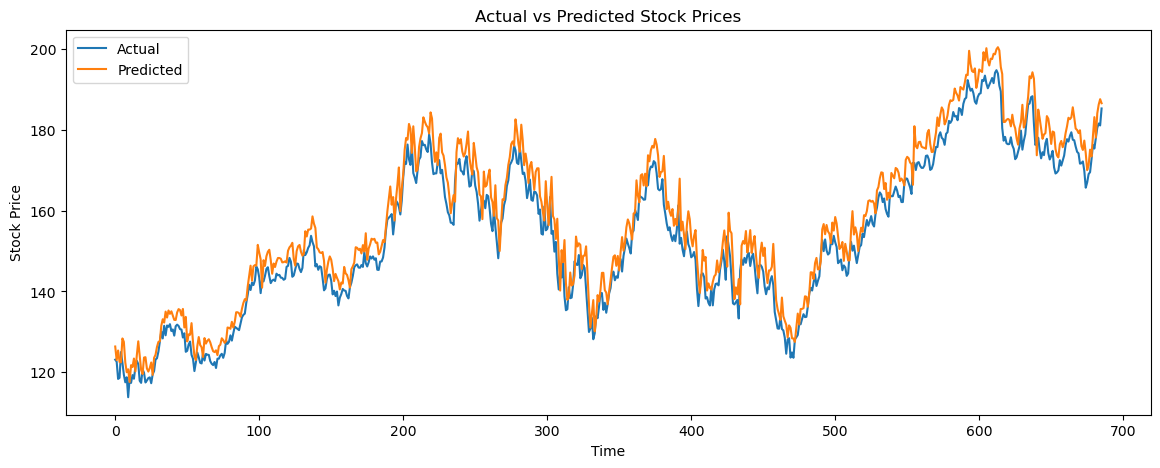

In [20]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(14,5))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

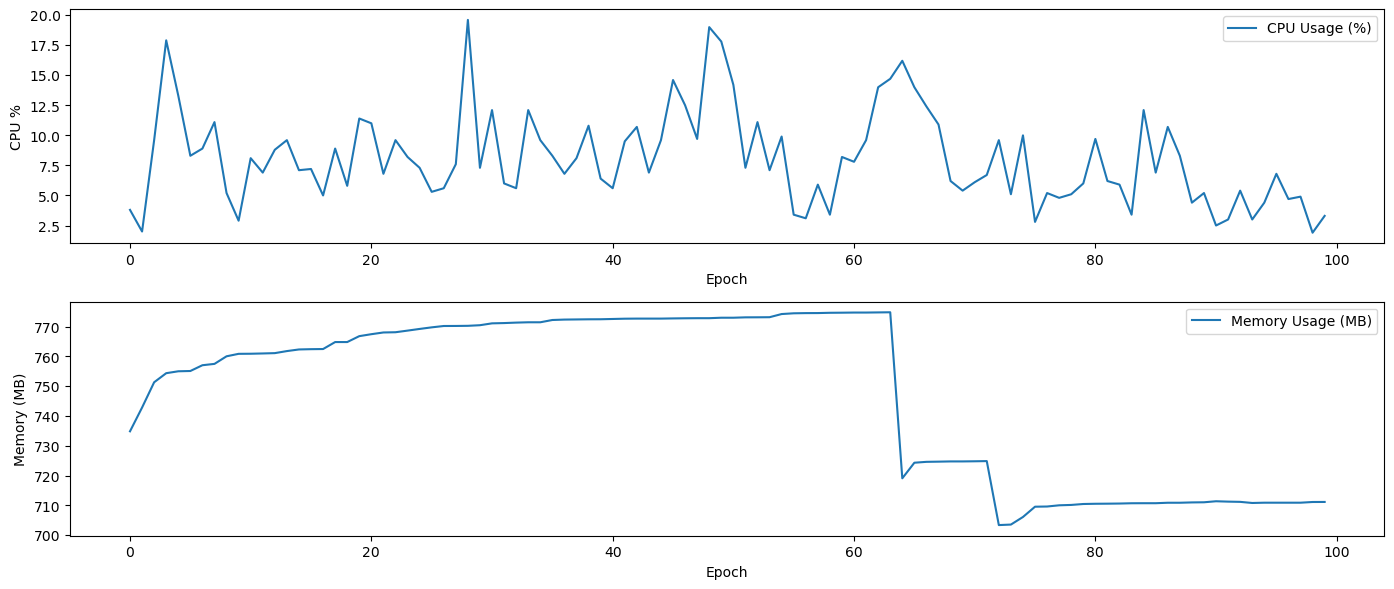

In [21]:
epochs = range(len(cpu_usage_log))

plt.figure(figsize=(14,6))

plt.subplot(2,1,1)
plt.plot(epochs, cpu_usage_log, label='CPU Usage (%)')
plt.xlabel("Epoch")
plt.ylabel("CPU %")
plt.legend()

plt.subplot(2,1,2)
plt.plot(epochs, memory_usage_log, label='Memory Usage (MB)')
plt.xlabel("Epoch")
plt.ylabel("Memory (MB)")
plt.legend()

plt.tight_layout()
plt.show()